# Bitcoin Stylized Facts & Tail Risk (BTC Daily)


This notebook provides an end-to-end empirical risk analysis of **BTCUSDT daily returns**:

- Data quality checks (OHLC sanity, missing bars)
- Feature engineering (log returns, rolling volatility, drawdown)
- Stylized facts (non-normality, heavy tails, volatility clustering)
- Tail risk: historical VaR/CVaR + rolling VaR/CVaR
- VaR backtesting: exceptions + **Kupiec POF** test
- Risk regimes: high/medium/low risk labeling based on rolling VaR
- Extreme Value Theory: **POT–GPD** fit and extreme VaR extrapolation

**Data expected:** Binance BTCUSDT daily bars (Kaggle) or any OHLCV daily CSV with similar columns.


## 0. Configuration


In [162]:
# --- Configuration ---
RAW_CSV_PATH = "btc_1d_data_2018_to_2025.csv"         # raw Kaggle export (recommended local, not committed)
PROCESSED_CSV_PATH = "btc_1d_clean.csv"      # optional: your processed features file

USE_PROCESSED_IF_AVAILABLE = True

# Risk parameters
ALPHA_VAR = 0.01
ROLLING_WINDOW = 250

# EVT parameters
POT_TAIL_PROB = 0.05        # model worst 5% losses
EVT_LEVELS = [0.01, 0.005, 0.001]  # 1%, 0.5%, 0.1%

# Regime thresholds based on VaR quantiles
HIGH_RISK_Q = 0.25
LOW_RISK_Q  = 0.75


## 1. Imports


In [163]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
plt.rcParams["figure.figsize"] = (12, 5)


## 2. Helper Functions


In [164]:
def _infer_datetime_from_open_time(series: pd.Series) -> pd.Series:
    """Infer datetime from open_time that may be in seconds or milliseconds."""
    s = pd.to_numeric(series, errors="coerce")
    if s.notna().mean() < 0.5:
        # Fallback: try parse as string dates
        return pd.to_datetime(series, errors="coerce")

    # Heuristic: milliseconds are typically > 1e12, seconds > 1e9 for modern timestamps
    med = s.dropna().median()
    if med > 1e12:
        return pd.to_datetime(s, unit="ms", errors="coerce")
    return pd.to_datetime(s, unit="s", errors="coerce")


def load_kaggle_binance_ohlcv(path: str) -> pd.DataFrame:
    """Load Binance/Kaggle OHLCV. Normalizes columns and creates a `date` column."""
    df = pd.read_csv(path)

    # Normalize column names
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

    # Common renames
    rename_map = {
        "number_of_trades": "num_trades",
        "taker_buy_base_asset_volume": "taker_buy_base_volume",
        "taker_buy_quote_asset_volume": "taker_buy_quote_volume",
        "quote_asset_volume": "quote_asset_volume",
    }
    df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

    # Create `date`
    if "date" not in df.columns:
        if "open_time" in df.columns:
            df["date"] = _infer_datetime_from_open_time(df["open_time"])
        elif "timestamp" in df.columns:
            df["date"] = pd.to_datetime(df["timestamp"], errors="coerce")
        else:
            raise ValueError("Could not find a time column. Expected `open_time` or `date` or `timestamp`.")

    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).sort_values("date")

    # Enforce numeric OHLCV where present
    num_cols = [c for c in ["open","high","low","close","volume","quote_asset_volume","num_trades",
                            "taker_buy_base_volume","taker_buy_quote_volume"] if c in df.columns]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df


def add_features(df: pd.DataFrame, price_col: str = "close") -> pd.DataFrame:
    """Add log returns, 30d/90d annualized volatility, and drawdown."""
    out = df.copy()
    out = out.sort_values("date")

    # Log returns
    out["log_ret"] = np.log(out[price_col]).diff()

    # Annualized rolling vol (crypto trades 24/7 => sqrt(365))
    out["vol_30d_ann"] = out["log_ret"].rolling(30).std() * np.sqrt(365)
    out["vol_90d_ann"] = out["log_ret"].rolling(90).std() * np.sqrt(365)

    # Drawdown (equity curve proxy)
    equity = np.exp(out["log_ret"].fillna(0).cumsum())
    peak = equity.cummax()
    out["drawdown"] = equity / peak - 1.0
    return out


def summary_stats(returns: pd.Series) -> dict:
    r = pd.to_numeric(returns, errors="coerce").dropna()
    return {
        "n": int(r.shape[0]),
        "mean": float(r.mean()),
        "std": float(r.std(ddof=1)),
        "min": float(r.min()),
        "max": float(r.max()),
        "skew": float(stats.skew(r, bias=False)),
        "kurtosis_excess": float(stats.kurtosis(r, fisher=True, bias=False)),
    }


def normality_tests(returns: pd.Series) -> dict:
    r = pd.to_numeric(returns, errors="coerce").dropna()
    jb_stat, jb_p = stats.jarque_bera(r)
    k2_stat, k2_p = stats.normaltest(r)
    return {
        "jb_stat": float(jb_stat),
        "jb_p_value": float(jb_p),
        "dagostino_k2_stat": float(k2_stat),
        "dagostino_k2_p_value": float(k2_p),
        "skew": float(stats.skew(r, bias=False)),
        "kurtosis": float(stats.kurtosis(r, fisher=False, bias=False)),
    }


def arch_lm_test(returns: pd.Series, lags: int = 12) -> dict:
    r = pd.to_numeric(returns, errors="coerce").dropna()
    lm_stat, lm_p, f_stat, f_p = het_arch(r, nlags=lags)
    return {
        "lags": int(lags),
        "lm_stat": float(lm_stat),
        "lm_p_value": float(lm_p),
        "f_stat": float(f_stat),
        "f_p_value": float(f_p),
    }


def acf_table(returns: pd.Series, nlags: int = 40) -> pd.DataFrame:
    r = pd.to_numeric(returns, errors="coerce").dropna()
    series_map = {
        "returns": r,
        "abs_returns": r.abs(),
        "sq_returns": r.pow(2),
    }
    rows = []
    for name, s in series_map.items():
        vals = acf(s, nlags=nlags, fft=True)
        for lag, v in enumerate(vals):
            rows.append({"series": name, "lag": lag, "acf": float(v)})
    return pd.DataFrame(rows)


def historical_var_cvar(returns: pd.Series, alpha: float = 0.01) -> tuple[float, float]:
    """Historical (empirical) VaR/CVaR on returns (left tail)."""
    r = pd.to_numeric(returns, errors="coerce").dropna()
    if len(r) == 0:
        raise ValueError("No valid returns supplied.")
    var = float(np.quantile(r, alpha))
    tail = r[r <= var]
    cvar = float(tail.mean())
    return var, cvar


def rolling_var_cvar(returns: pd.Series, window: int = 250, alpha: float = 0.01) -> pd.DataFrame:
    """Rolling historical VaR/CVaR."""
    r = pd.to_numeric(returns, errors="coerce").dropna()
    rows = []
    for i in range(window, len(r)):
        hist = r.iloc[i-window:i]
        var, cvar = historical_var_cvar(hist, alpha=alpha)
        rows.append({"date": r.index[i], "var": var, "cvar": cvar})
    return pd.DataFrame(rows).set_index("date")


def historical_var_cvar_position(
    returns: pd.Series,
    alpha: float = 0.01,
    side: str = "long",
    notional: float = 1.0,
) -> tuple[float, float]:
    """Historical VaR/CVaR in LOSS FORM for long/short positions."""
    r = pd.to_numeric(returns, errors="coerce").dropna()

    if side == "long":
        pnl = notional * r
    elif side == "short":
        pnl = -notional * r
    else:
        raise ValueError("side must be 'long' or 'short'.")

    losses = -pnl  # positive is loss
    var_loss = float(np.quantile(losses, 1 - alpha))
    tail = losses[losses >= var_loss]
    cvar_loss = float(tail.mean())
    return var_loss, cvar_loss


def find_exceptions(returns: pd.Series, var_series: pd.Series) -> pd.DataFrame:
    df = pd.concat([returns.rename("ret"), var_series.rename("var")], axis=1).dropna()
    df["exception"] = (df["ret"] <= df["var"]).astype(int)
    return df


def kupiec_pof_test(exceptions: pd.Series, alpha: float = 0.01) -> dict:
    """Kupiec Proportion of Failures (unconditional coverage) test."""
    ex = pd.to_numeric(exceptions, errors="coerce").dropna().astype(int)
    T = int(ex.shape[0])
    X = int(ex.sum())
    p_hat = X / T if T > 0 else np.nan

    if T == 0:
        raise ValueError("No observations for Kupiec test.")
    if p_hat in (0.0, 1.0):
        return {"T": T, "X": X, "p_hat": float(p_hat), "LR_uc": float("inf"), "p_value": 0.0}

    # LR_uc = -2 log(L0/L1)
    # L0: alpha, L1: p_hat
    term1 = (T - X) * np.log((1 - alpha) / (1 - p_hat))
    term2 = X * np.log(alpha / p_hat)
    LR_uc = float(-2 * (term1 + term2))
    p_value = float(1 - stats.chi2.cdf(LR_uc, df=1))
    return {"T": T, "X": X, "p_hat": float(p_hat), "LR_uc": LR_uc, "p_value": p_value}


def label_var_regimes(rolling: pd.DataFrame, high_q: float = 0.25, low_q: float = 0.75) -> tuple[pd.DataFrame, float, float]:
    out = rolling.copy()
    q_high = float(out["var"].quantile(high_q))  # more negative
    q_low  = float(out["var"].quantile(low_q))   # less negative

    def classify(v: float) -> str:
        if v <= q_high:
            return "high"
        if v >= q_low:
            return "low"
        return "medium"

    out["risk_regime"] = out["var"].apply(classify)
    return out, q_high, q_low



def summarize_regime_episodes(rolling_labeled: pd.DataFrame) -> pd.DataFrame:
    df = rolling_labeled.copy().sort_index()
    df["date"] = df.index

    # Create block id whenever regime changes
    df["regime_block"] = (df["risk_regime"] != df["risk_regime"].shift()).cumsum()

    episodes = (
        df.groupby(["risk_regime", "regime_block"], as_index=False)
          .agg(
              start=("date", "min"),
              end=("date", "max"),
              days=("date", "size"),
              mean_var=("var", "mean"),
              mean_cvar=("cvar", "mean"),
          )
    )
    return episodes



# EVT (POT–GPD)
from scipy.stats import genpareto

def fit_pot_gpd_left(returns: pd.Series, tail_prob: float = 0.05, min_exceedances: int = 30) -> dict:
    r = pd.to_numeric(returns, errors="coerce").dropna()
    if len(r) == 0:
        raise ValueError("No valid returns supplied.")
    if not (0 < tail_prob < 1):
        raise ValueError("tail_prob must be in (0, 1).")

    losses = -r
    u = float(np.quantile(losses, 1.0 - tail_prob))
    exceedances = losses[losses > u] - u
    n_exc = int(exceedances.shape[0])

    if n_exc < min_exceedances:
        raise ValueError(f"Too few exceedances ({n_exc}). Increase tail_prob or add data.")

    shape, loc, scale = genpareto.fit(exceedances, floc=0.0)
    return {
        "tail_prob": float(tail_prob),
        "threshold_loss": float(u),
        "n_exc": int(n_exc),
        "shape": float(shape),  # xi
        "scale": float(scale),  # beta
    }


def gpd_var_left_from_fit(alpha: float, total_n: int, pot_res: dict) -> tuple[float, float]:
    """Return-form VaR (negative) and loss-form VaR (positive)."""
    u = float(pot_res["threshold_loss"])
    xi = float(pot_res["shape"])
    beta = float(pot_res["scale"])
    n_exc = int(pot_res["n_exc"])

    p_u = n_exc / total_n
    if alpha >= p_u:
        raise ValueError(f"alpha ({alpha}) must be smaller than p_u ({p_u:.4f}) to extrapolate beyond threshold.")

    q_loss = u + (beta / xi) * ((alpha / p_u) ** (-xi) - 1.0)
    var_loss = float(q_loss)
    var_ret = -var_loss
    return var_ret, var_loss


## 3. Load Data


In [165]:
# Decide which input file to use
use_processed = USE_PROCESSED_IF_AVAILABLE and os.path.exists(PROCESSED_CSV_PATH)

if use_processed:
    df = pd.read_csv(PROCESSED_CSV_PATH)
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    df["date"] = pd.to_datetime(df["date"]).dt.floor("D")
else:
    if not os.path.exists(RAW_CSV_PATH):
        raise FileNotFoundError(
            f"Raw CSV not found at: {RAW_CSV_PATH}. "
            "Update RAW_CSV_PATH or place the Kaggle CSV under data/raw/."
        )
    df = load_kaggle_binance_ohlcv(RAW_CSV_PATH)

df = df.sort_values("date").reset_index(drop=True)
df.head()


,date,open,high,low,close,volume,quote_asset_volume,num_trades,taker_buy_base_volume,taker_buy_quote_volume,timeframe
0,2018-01-01,13715.65,13818.55,12750.00,13380.00,8609.915844,1.147997e+08,105595,3961.938946,5.280975e+07,1d
1,2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111,2.797171e+08,177728,11346.326739,1.580801e+08,1d
2,2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.667639,2.361169e+08,162787,8994.953566,1.335873e+08,1d
3,2018-01-04,14919.51,15280.00,13918.04,15059.54,21329.649574,3.127816e+08,170310,12680.812951,1.861168e+08,1d
4,2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.491125,3.693220e+08,192969,13346.622293,2.118299e+08,1d


## 4. Data Quality Checks


In [166]:
# Basic dataset info
print("Date range:", df["date"].min().date(), "→", df["date"].max().date())
print("Shape:", df.shape)

# Missing daily bars check (requires daily frequency)
date_floor = pd.to_datetime(df["date"]).dt.floor("D")
all_days = pd.date_range(date_floor.min(), date_floor.max(), freq="D")
missing = all_days.difference(date_floor)
print("Missing daily bars:", len(missing))

# OHLC sanity checks (if columns exist)
ohlc_cols = [c for c in ["open","high","low","close"] if c in df.columns]
if ohlc_cols:
    print("Any negative prices?", (df[ohlc_cols] < 0).any().any())
    if set(["high","low"]).issubset(df.columns):
        print("High < Low rows:", int((df["high"] < df["low"]).sum()))


Date range: 2018-01-01 → 2025-12-08
Shape: (2899, 11)
Missing daily bars: 0
Any negative prices? False
High < Low rows: 0


## 5. Feature Engineering


In [167]:
# Add features if needed
if "log_ret" not in df.columns:
    df = add_features(df, price_col="close")

# Ensure date is datetime (only if date is still a column)
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")

# Sort by date index
df = df.sort_index()

# Keep only rows where return exists
btc = df.dropna().copy()

btc[["close", "log_ret", "vol_30d_ann", "drawdown"]].head()
btc

,open,high,low,close,volume,quote_asset_volume,num_trades,taker_buy_base_volume,taker_buy_quote_volume,timeframe,log_ret,vol_30d_ann,vol_90d_ann,drawdown
date,,,,,,,,,,,,,,
2018-04-01,6922.00,7049.98,6430.00,6813.01,44071.430463,2.974705e+08,260942,21899.300660,1.479512e+08,1d,-0.016147,0.888650,1.211086,-0.600873
2018-04-02,6813.01,7125.00,6765.00,7056.00,32123.560072,2.243222e+08,206780,16365.683591,1.142924e+08,1d,0.035044,0.886582,1.197114,-0.586638
2018-04-03,7063.97,7520.00,7011.01,7405.21,37787.331811,2.770801e+08,248143,19218.850485,1.408922e+08,1d,0.048305,0.912265,1.201502,-0.566180
2018-04-04,7405.21,7427.52,6707.00,6796.10,42227.183804,2.974436e+08,277249,20299.402203,1.428910e+08,1d,-0.085835,0.944486,1.211188,-0.601864
2018-04-05,6796.10,6902.00,6566.69,6770.76,39029.731460,2.634469e+08,238476,18991.102712,1.282708e+08,1d,-0.003736,0.928620,1.183009,-0.603348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-04,93429.95,93750.73,92669.82,93397.10,1591.346430,1.482571e+08,413549,587.421300,5.474755e+07,1d,0.017592,0.535628,0.428646,-0.253104
2025-12-05,92078.06,92500.00,92058.82,92449.92,383.084960,3.536115e+07,198293,168.284200,1.553242e+07,1d,-0.010193,0.489823,0.428806,-0.260678
2025-12-06,89330.04,89466.34,89030.67,89382.00,331.317770,2.957271e+07,125516,142.576780,1.272914e+07,1d,-0.033748,0.485637,0.432995,-0.285212


### Feature Plots


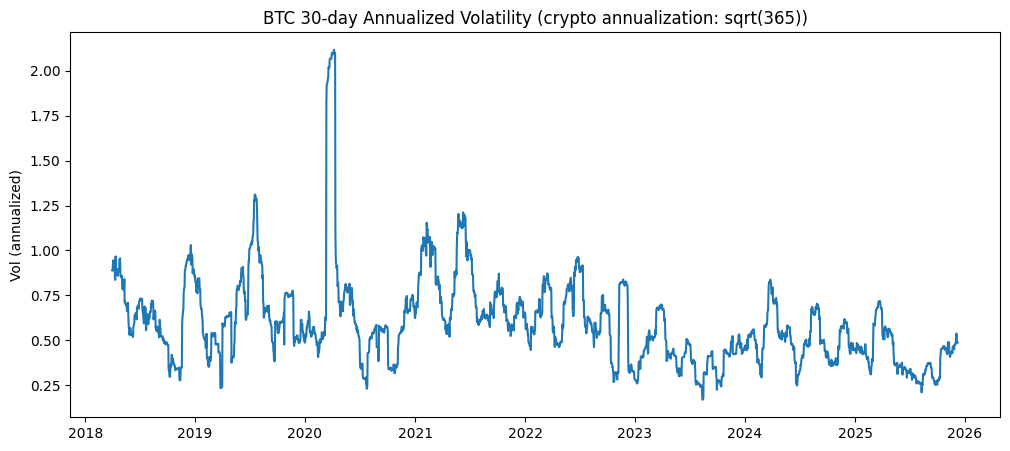

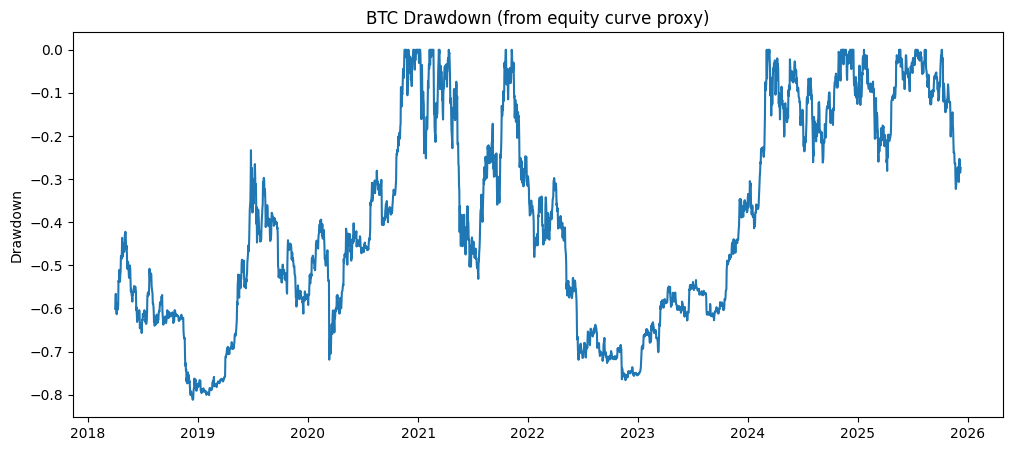

In [168]:
# Rolling volatility and drawdown plots
fig, ax = plt.subplots()
ax.plot(btc.index, btc["vol_30d_ann"])
ax.set_title("BTC 30-day Annualized Volatility (crypto annualization: sqrt(365))")
ax.set_ylabel("Vol (annualized)")
plt.show()

fig, ax = plt.subplots()
ax.plot(btc.index, btc["drawdown"])
ax.set_title("BTC Drawdown (from equity curve proxy)")
ax.set_ylabel("Drawdown")
plt.show()


## Interpretation — Volatility and Drawdown

### 30-day Annualized Volatility (√365)
This chart shows BTC's **rolling 30-day volatility** computed from daily log returns and annualized using **sqrt(365)** (crypto trades 7 days/week).

**Key takeaways**
- **Volatility clustering** is evident: periods of high volatility tend to persist, followed by calmer regimes.
- A major **stress spike around early 2020** indicates an extreme tail-risk environment, where large negative returns are more likely.
- Post-spike, volatility generally **mean-reverts**, but regime changes occur over months/years rather than day-to-day.

**Why it matters**
Rolling volatility is a practical **risk-regime proxy**. When volatility is elevated, we expect **more severe VaR/CVaR and more exceptions** in backtests.

### Drawdown (peak-to-trough decline)
Drawdown measures the percentage decline from the running peak of the BTC price/equity curve. Values are always ≤ 0:
- `0.00` = new peak
- `-0.50` = 50% below the prior peak

**Key takeaways**
- BTC exhibits **large and persistent drawdowns**, consistent with fat tails and crash risk.
- Deep drawdown episodes indicate prolonged risk regimes where losses compound and recovery can take significant time.
- Drawdown complements VaR/CVaR: VaR/CVaR quantify **one-day tail loss**, while drawdown captures **multi-week/month downside path risk**.


## 6. Stylized Facts


In [169]:
r = btc["log_ret"]

stats_out = summary_stats(r)
norm_out = normality_tests(r)
arch_out = arch_lm_test(r, lags=12)
acf_out = acf_table(r, nlags=40)

print("Summary:", stats_out)
print("Normality:", norm_out)
print("ARCH LM:", arch_out)

acf_out.head()


Summary: {'n': 2809, 'mean': 0.0009160780926266003, 'std': 0.033662392983979945, 'min': -0.5026069427414583, 'max': 0.17844855970428242, 'skew': -1.183267133820723, 'kurtosis_excess': 20.437446245901516}
Normality: {'jb_stat': 49357.83913812266, 'jb_p_value': 0.0, 'dagostino_k2_stat': 1132.721955794455, 'dagostino_k2_p_value': 1.0778356248862857e-246, 'skew': -1.183267133820723, 'kurtosis': 23.437446245901516}
ARCH LM: {'lags': 12, 'lm_stat': 47.04195854561187, 'lm_p_value': 4.584310784965349e-06, 'f_stat': 3.968691237488828, 'f_p_value': 4.125514479293972e-06}


,series,lag,acf
0,returns,0,1.000000
1,returns,1,-0.070347
2,returns,2,0.049325
3,returns,3,-0.005088
4,returns,4,0.044319


### Stylized Facts Plots


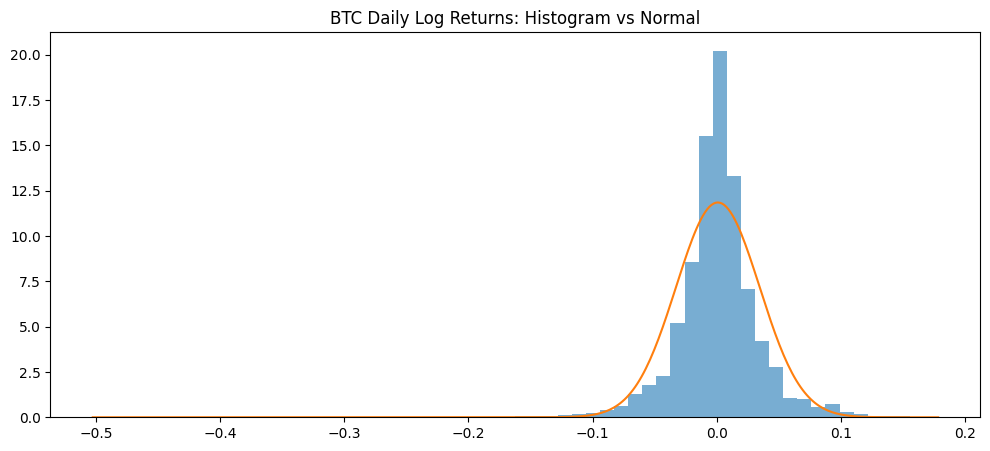

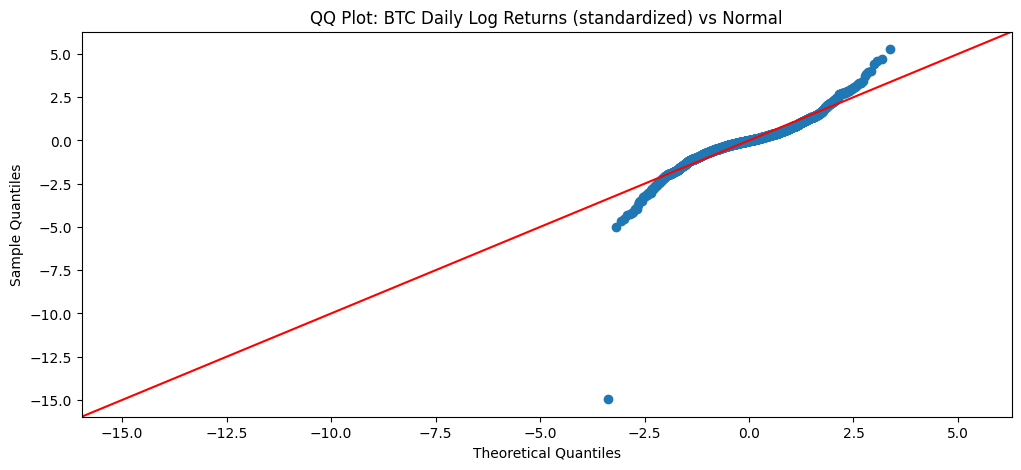

In [170]:
fig, ax = plt.subplots()
ax.hist(r, bins=60, density=True, alpha=0.6)
mu, sigma = r.mean(), r.std(ddof=1)
x = np.linspace(r.min(), r.max(), 400)
ax.plot(x, stats.norm.pdf(x, mu, sigma))
ax.set_title("BTC Daily Log Returns: Histogram vs Normal")
plt.show()

# QQ plot (fix: standardize)
z = (r - r.mean()) / r.std(ddof=1)

fig = qqplot(z, line="45")
plt.title("QQ Plot: BTC Daily Log Returns (standardized) vs Normal")
plt.show()


### Interpretation — Histogram vs Normal

The histogram of BTC daily log returns is **much more peaked around 0** than the fitted Normal curve and shows **fatter tails**.

Key takeaways:
- **Leptokurtosis (fat tails):** extreme moves happen more often than a Normal model predicts, so Normal-based risk estimates tend to **underestimate tail risk**.
- **Asymmetry (skew):** the distribution is not perfectly symmetric; in BTC it is often **negatively skewed**, meaning large losses can be more extreme than large gains.
- Practical implication: a Normal assumption is a weak baseline for crypto returns; tail-focused risk tools (VaR/CVaR, EVT) are more appropriate.
Supporting stats (this dataset):
- skew ≈ -1.18 (negative)
- excess kurtosis ≈ 20.44 (very fat tails)
- Jarque–Bera p-value ≈ 0 → rejects normality


### Interpretation — QQ Plot vs Normal (standardized)

If returns were Normal, points would lie close to the red 45° line.  
Instead, the plot bends away from the line in both tails:

- **Left tail (losses):** points fall far from the line, indicating **more extreme negative returns** than Normal would expect (downside tail risk).
- **Right tail (gains):** points also deviate upward, indicating **more extreme positive returns** than Normal would expect.
- Overall shape indicates **fat tails** and **non-normality**, consistent with the stylized facts of crypto returns.

Conclusion: risk models relying on Normality will misprice tail events; this motivates **VaR/CVaR** and **EVT (POT–GPD)** for tail modeling.


## Interpretation — Returns distribution vs Normal

### Histogram vs Normal
The histogram compares empirical BTC daily log returns to a fitted Normal distribution (same mean and standard deviation).
The empirical distribution is **more peaked around zero** and has **fatter tails** than Normal, indicating that extreme returns occur more often than a Gaussian model would predict.  
This implies that **normal-based risk metrics underestimate tail risk**, particularly during stress periods.

### QQ Plot vs Normal
The QQ plot checks whether return quantiles match Normal quantiles. If returns were Normal, the points would lie on the reference line.
Instead, the tails deviate strongly:
- The **left tail** diverges downward, showing **more severe losses** than Normal would predict.
- The **right tail** also diverges upward, showing **larger gains** than Normal.

Overall, these plots provide visual confirmation of **fat tails (high kurtosis)** and **asymmetry (skewness)**, motivating tail-focused risk measures such as **VaR/CVaR** and **EVT (POT–GPD)**.


## 7. Tail Risk: Historical VaR/CVaR


In [171]:
# Historical VaR/CVaR on the full sample (returns form)
for a in [0.05, 0.01]:
    var, cvar = historical_var_cvar(r, alpha=a)
    print(f"Historical VaR (alpha={a:.3f}): {var:.4f}, CVaR: {cvar:.4f}")

# Rolling VaR/CVaR
rolling = rolling_var_cvar(r, window=ROLLING_WINDOW, alpha=ALPHA_VAR)
rolling.head()


Historical VaR (alpha=0.050): -0.0518, CVaR: -0.0797
Historical VaR (alpha=0.010): -0.0937, CVaR: -0.1321


,var,cvar
date,,
2018-12-07,-0.103898,-0.121733
2018-12-08,-0.103898,-0.121733
2018-12-09,-0.103898,-0.121733
2018-12-10,-0.103898,-0.121733
2018-12-11,-0.103898,-0.121733


### Rolling VaR/CVaR Plot


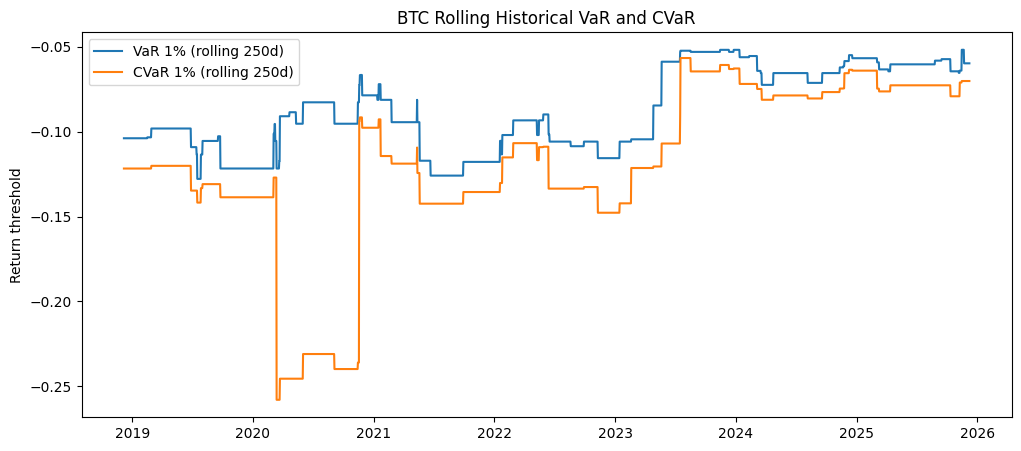

Min VaR: -0.12782692668627565
Min CVaR: -0.25797278071257007


In [172]:
fig, ax = plt.subplots()
ax.plot(rolling.index, rolling["var"], label=f"VaR {ALPHA_VAR:.0%} (rolling {ROLLING_WINDOW}d)")
ax.plot(rolling.index, rolling["cvar"], label=f"CVaR {ALPHA_VAR:.0%} (rolling {ROLLING_WINDOW}d)")
ax.set_title("BTC Rolling Historical VaR and CVaR")
ax.set_ylabel("Return threshold")
ax.legend()
plt.show()

print("Min VaR:", float(rolling["var"].min()))
print("Min CVaR:", float(rolling["cvar"].min()))


### Interpretation — Rolling 1% Historical VaR and CVaR (250-day window)

This plot shows two rolling downside risk measures computed from the last **250 trading days** of BTC daily log returns:

- **VaR 1% (blue):** the 1% empirical quantile of returns (left tail).  
  Meaning: based on the last 250 days, only ~1% of days are expected to have returns worse than this threshold.
- **CVaR 1% (orange):** the **average return conditional on being in the worst 1% tail** (returns ≤ VaR).  
  Meaning: the expected loss magnitude on a “bad tail day.”

**Key relationship**
- CVaR is always **below (more negative than) VaR**, because it averages the extreme losses beyond the VaR cutoff.

**What the time variation means**
- When both lines move **downward (more negative)**, the recent 250-day history contains larger downside moves → **risk regime is worse** (fatter left tail / higher downside volatility).
- When they move **upward (closer to 0)**, downside losses in the recent window are smaller → **risk is lower**.

**Notable stress period**
- The largest downside tail risk appears around **2020**, where CVaR drops sharply.  
  This indicates that within that rolling window the worst tail days were substantially worse than usual.

**Your extreme values (from the printout)**
- **Min rolling VaR (1%)** = **-0.1278**  
  Interpretation: in the most stressed 250-day window, the 1% daily return threshold implied about a **12.78% loss** day (in return units).
- **Min rolling CVaR (1%)** = **-0.2580**  
  Interpretation: conditional on being in the worst 1% tail during that window, the **average tail-day return** was about **-25.8%** (much more severe than VaR).

**Why the lines look “step-like”**
- These are historical quantiles over a fixed window. VaR/CVaR only change when the rolling window drops/introduces observations that affect the 1% tail.


## 8. Tail Risk by Position (Long vs Short)


In [173]:
# Loss-form VaR/CVaR for long and short positions
for side in ["long", "short"]:
    var_loss, cvar_loss = historical_var_cvar_position(r, alpha=0.01, side=side, notional=1.0)
    print(f"{side.capitalize()} 1% VaR (loss): {var_loss:.4f}, CVaR (loss): {cvar_loss:.4f}")


Long 1% VaR (loss): 0.0937, CVaR (loss): 0.1321
Short 1% VaR (loss): 0.0946, CVaR (loss): 0.1150


## 9. VaR Backtesting: Exceptions + Kupiec POF


Empirical exception rate: 0.012504884720593983


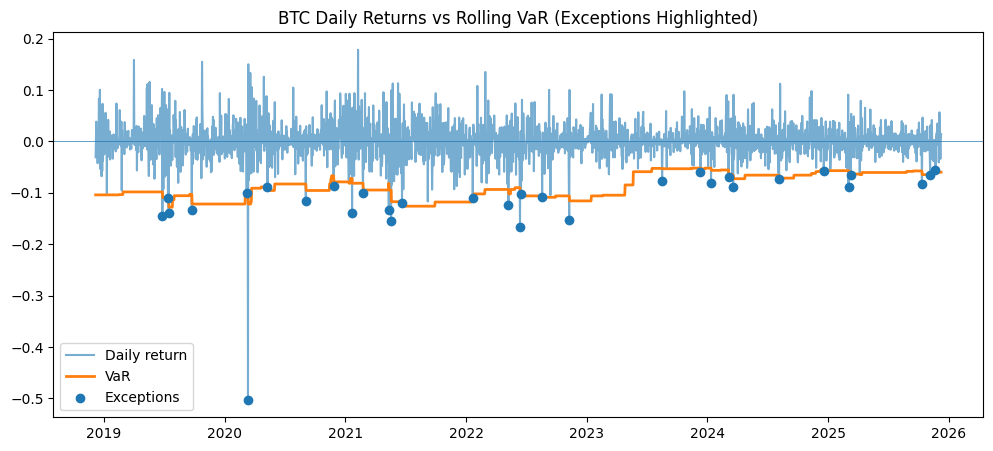

Kupiec POF: {'T': 2559, 'X': 32, 'p_hat': 0.012504884720593983, 'LR_uc': 1.5024243601507479, 'p_value': 0.2202987110172826}


In [174]:
# VaR backtest (exceptions)
aligned = find_exceptions(r.loc[rolling.index], rolling["var"])
exception_rate = float(aligned["exception"].mean())
print("Empirical exception rate:", exception_rate)

exceptions = aligned[aligned["exception"] == 1]

fig, ax = plt.subplots()
ax.plot(aligned.index, aligned["ret"], label="Daily return", alpha=0.6)
ax.plot(aligned.index, aligned["var"], label="VaR", linewidth=2)
ax.scatter(exceptions.index, exceptions["ret"], label="Exceptions", zorder=3)
ax.axhline(0, linewidth=0.5)
ax.set_title("BTC Daily Returns vs Rolling VaR (Exceptions Highlighted)")
ax.legend()
plt.show()

# Kupiec test
kupiec = kupiec_pof_test(aligned["exception"], alpha=ALPHA_VAR)
print("Kupiec POF:", kupiec)


### Interpretation — Daily Returns vs Rolling 1% VaR (Exceptions Highlighted)

This chart overlays:
- **Daily returns** (blue vertical spikes),
- **Rolling 1% historical VaR** (orange step line),
- **Exceptions** (dots): days where the realized return is **worse than the VaR threshold** (i.e., return ≤ VaR).

**How to read it**
- The orange VaR line is a **time-varying loss threshold** estimated from a rolling window of past returns.
- When the market becomes riskier (higher volatility / heavier downside tail in the recent window), VaR becomes **more negative** (drops downward).
- When the market is calmer, VaR moves **closer to zero** (less negative).
- Dots show **VaR breaches**—these are the tail-loss events the model aims to capture at frequency α.

**Calibration check (exception rate)**
- Target breach rate is **α = 1%**.
- Observed breach rate is **p̂ = 0.01250 (1.25%)** with **X = 32 breaches** over **T = 2559 days**.
- Since 1.25% is close to 1%, the VaR is **reasonably calibrated**, but slightly conservative/underestimating risk (breaches are a bit more frequent than expected).

**Kupiec POF backtest (unconditional coverage)**
- Kupiec test p-value = **0.2203**.
- Because p-value > 0.05, we **fail to reject** correct unconditional coverage.
- Interpretation: the model’s *overall* breach frequency is statistically consistent with α = 1% (no strong evidence that the VaR is miscalibrated in frequency).

**Practical notes**
- The step-like shape of VaR comes from using a fixed rolling window: VaR updates as the window moves.
- Clusters of exceptions often occur during stress periods; even if unconditional coverage passes, you may still check **independence / clustering** using the **Christoffersen test** (conditional coverage).


## 10. Risk Regimes from Rolling VaR


In [175]:
rolling_labeled, high_thr, low_thr = label_var_regimes(rolling, high_q=HIGH_RISK_Q, low_q=LOW_RISK_Q)
print(f"High-risk threshold (VaR <= {high_thr:.6f})")
print(f"Low-risk threshold  (VaR >= {low_thr:.6f})")

# Regime summary
regime_summary = rolling_labeled.groupby("risk_regime")[["var","cvar"]].agg(["count","mean","min","max"])
regime_summary


High-risk threshold (VaR <= -0.105871)
Low-risk threshold  (VaR >= -0.063337)


var                                cvar                      \
            count      mean       min       max count      mean       min   
risk_regime                                                                 
high          658 -0.117281 -0.127827 -0.105871   658 -0.140863 -0.257973   
low           642 -0.056969 -0.063337 -0.051770   642 -0.071567 -0.106996   
medium       1259 -0.088171 -0.105859 -0.064040  1259 -0.131580 -0.245554   

                       
                  max  
risk_regime            
high        -0.130263  
low         -0.056633  
medium      -0.071067

### Risk regimes from rolling 1% VaR (250-day window)

We label risk regimes using **rolling 1% historical VaR** (left-tail return threshold).  
Because VaR is reported in **returns**, *more negative VaR means worse tail risk*.

**Thresholds**
- **High-risk:** VaR ≤ **−0.105871**  (implies ≥ 10.6% daily loss at the 1% tail)
- **Low-risk:**  VaR ≥ **−0.063337**  (implies ≈ 6.3% daily loss at the 1% tail)
- **Medium-risk:** between these thresholds

---

## Regime summary (counts and tail severity)

### High-risk regime (658 days)
- **Mean VaR:** −0.1173  (typical 1% tail loss ≈ 11.7%)
- **Mean CVaR:** −0.1409 (average loss on exceedance days ≈ 14.1%)
- **Worst observed VaR:** −0.1278 (≈ 12.8% tail loss threshold)
- **Worst observed CVaR:** −0.2580 (≈ 25.8% average loss in the extreme tail)

**Interpretation:** This regime corresponds to stressed markets where both the 1% loss threshold and expected shortfall become materially larger. CVaR is substantially more negative than VaR, indicating a heavy and damaging left tail during stress.

---

### Medium-risk regime (1259 days)
- **Mean VaR:** −0.0882  (≈ 8.8% tail loss)
- **Mean CVaR:** −0.1316 (≈ 13.2% average tail loss)

**Interpretation:** The “baseline” regime in this labeling (largest number of days). Tail risk is elevated versus low-risk, and CVaR remains meaningfully worse than VaR, suggesting persistent fat tails even outside the highest-stress periods.

---

### Low-risk regime (642 days)
- **Mean VaR:** −0.0570  (≈ 5.7% tail loss)
- **Mean CVaR:** −0.0716 (≈ 7.2% average tail loss)
- **Worst low-regime CVaR:** −0.1070 (≈ 10.7% average loss in tail)

**Interpretation:** Quieter periods with comparatively smaller tail losses. However, CVaR still remains more negative than VaR, meaning extreme losses are still heavier than a thin-tailed model would suggest.

---

## Key takeaways
1. **VaR separates regimes by “how bad the 1% day can be.”** High-risk implies ≥ ~10–13% 1% tail loss thresholds.
2. **CVaR magnifies the difference.** High-risk CVaR can be dramatically worse (down to −25.8%), showing the tail can become very deep in stress.
3. **Most days fall into the medium regime** (1259), indicating BTC spends substantial time in an “intermediate tail-risk” state rather than staying mostly calm.


### Regime Plot


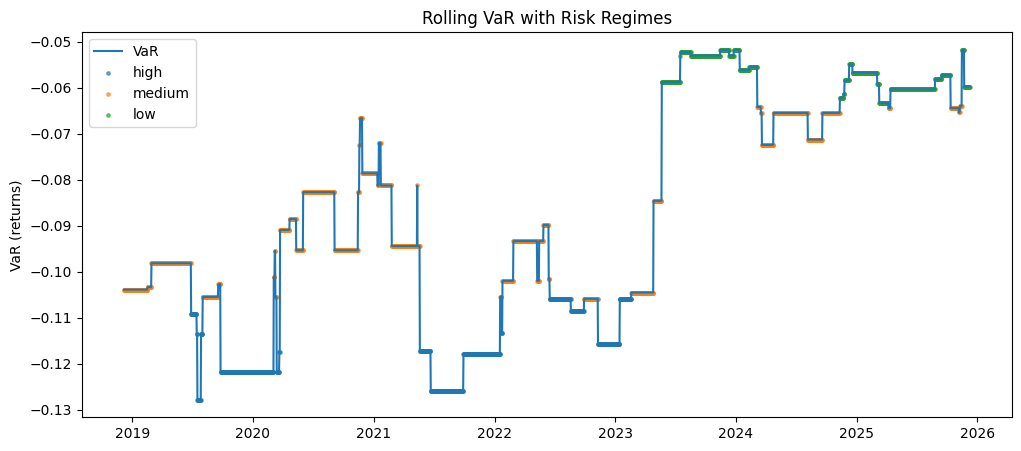

In [176]:
fig, ax = plt.subplots()
ax.plot(rolling_labeled.index, rolling_labeled["var"], label="VaR")
colors = {"high": "red", "medium": "orange", "low": "green"}
for regime, color in colors.items():
    mask = rolling_labeled["risk_regime"] == regime
    ax.scatter(rolling_labeled.index[mask], rolling_labeled.loc[mask, "var"], s=6, label=regime, alpha=0.6)
ax.set_title("Rolling VaR with Risk Regimes")
ax.set_ylabel("VaR (returns)")
ax.legend()
plt.show()


### Interpretation — Rolling VaR with Risk Regimes (High / Medium / Low)

This figure overlays the **rolling 1% historical VaR (250-day window)** with a simple **regime label** based on how negative VaR is.

#### What each element means
- **Blue line (VaR):** the 1% downside return threshold estimated from the prior 250 days.
  - More negative VaR ⇒ the left tail is worse ⇒ **higher downside risk**.
  - Less negative (closer to 0) ⇒ **lower downside risk**.
- **Colored markers:** regime classification at each date:
  - **High risk:** VaR is very negative (worst downside tail conditions).
  - **Medium risk:** VaR is between the two thresholds.
  - **Low risk:** VaR is relatively mild (closest to 0).

#### How to read the timeline
- **2019–2022:** VaR frequently sits in the **-0.10 to -0.13** area, and you see many **high/medium** points.
  - Interpretation: the rolling window repeatedly includes large negative daily moves → persistent downside tail stress.
- **From ~2023 onward:** VaR shifts upward to around **-0.06 to -0.07** with many **low-risk** points.
  - Interpretation: the recent 250-day history contains fewer / smaller extreme losses → improved tail conditions.
- **Step-like behavior:** VaR changes in discrete jumps because it is a **quantile** of a rolling sample; it updates only when the set of worst observations in the 250-day window changes.

#### What your thresholds mean (based on your outputs)
- **High-risk threshold:** VaR ≤ **-0.1039**
  - A “typical” worst 1% day implied by recent history is worse than ~**10.4%** return.
- **Low-risk threshold:** VaR ≥ **-0.0655**
  - The 1% tail threshold is milder than ~**6.6%** return.

#### Practical takeaway
This plot is a **regime detector for downside tail risk**:
- If the market enters **high-risk**, position sizing / leverage should usually be reduced and risk controls tightened.
- If the market is **low-risk**, tail conditions are calmer, but exceptions still occur (VaR is not a guarantee).



### High-risk Episodes


In [177]:
episodes = summarize_regime_episodes(rolling_labeled)

high_eps = (episodes[episodes["risk_regime"] == "high"]
            .sort_values("days", ascending=False))

high_eps.head(10)


,risk_regime,regime_block,start,end,days,mean_var,mean_cvar
3,high,8,2021-05-20,2022-01-17,243,-0.121021,-0.139303
1,high,4,2019-09-25,2020-03-03,161,-0.121718,-0.138666
5,high,12,2022-06-17,2022-09-28,104,-0.106915,-0.133565
6,high,14,2022-11-09,2023-02-18,102,-0.112186,-0.145727
0,high,2,2019-06-28,2019-08-01,35,-0.115883,-0.136750
2,high,6,2020-03-13,2020-03-22,10,-0.120844,-0.257973
4,high,10,2022-01-22,2022-01-24,3,-0.113384,-0.130263


## 11. EVT: POT–GPD for Extreme Tail Risk


In [178]:
# EVT (POT–GPD) fit on losses
N = int(r.shape[0])
pot = fit_pot_gpd_left(r, tail_prob=POT_TAIL_PROB)

print("POT tail_prob:", pot["tail_prob"])
print("Threshold loss u:", pot["threshold_loss"])
print("Exceedances:", pot["n_exc"])
print("GPD shape xi:", pot["shape"])
print("GPD scale beta:", pot["scale"])

# EVT VaR extrapolation
for a in EVT_LEVELS:
    var_ret, var_loss = gpd_var_left_from_fit(a, N, pot)
    print(f"EVT VaR (alpha={a}): return {var_ret:.4f}, loss {var_loss:.4f}")


POT tail_prob: 0.05
Threshold loss u: 0.05180695291881171
Exceedances: 141
GPD shape xi: 0.20523652387629418
GPD scale beta: 0.02174386331370043
EVT VaR (alpha=0.01): return -0.0934, loss 0.0934
EVT VaR (alpha=0.005): return -0.1159, loss 0.1159
EVT VaR (alpha=0.001): return -0.1825, loss 0.1825


### EVT (POT–GPD) Tail-Risk Results

This section models the **left tail (losses)** using **Extreme Value Theory (EVT)** with the **Peaks-Over-Threshold (POT)** approach.  
Instead of using all returns, POT focuses only on sufficiently large losses and fits a **Generalized Pareto Distribution (GPD)** to those exceedances.

---

## 1) Inputs / fit summary

- **Tail probability used for fitting (`tail_prob = 0.05`)**  
  We choose a threshold so that roughly the worst **5%** of observations (largest losses) are treated as “tail events.”

- **Threshold loss `u = 0.0518`**  
  This is the cutoff: a **daily loss larger than ~5.18%** is considered a tail exceedance.

- **Number of exceedances = 141**  
  There are 141 daily losses worse than `u` used to fit the GPD.

---

## 2) GPD parameters (what they mean)

- **Shape parameter `xi = 0.2052` (positive)**  
  Positive `xi` implies a **heavy tail** (Pareto-like).  
  Practical meaning: **extreme losses decay slowly**, so very large drawdowns are more plausible than under a Normal assumption.

- **Scale parameter `beta = 0.0217`**  
  This controls the **spread/intensity** of losses *beyond* the threshold.  
  Larger `beta` would mean exceedances vary more and can get large faster.

---

## 3) EVT-based VaR estimates (tail extrapolation)

You computed EVT VaR for rarer levels than the 5% threshold by extrapolating the fitted tail:

- **EVT VaR (α = 1%)**: return **−0.0934** → **loss 9.34%**  
  Interpretation: on about **1 out of 100 days**, a loss of **~9.3% or worse**.

- **EVT VaR (α = 0.5%)**: return **−0.1159** → **loss 11.59%**  
  Interpretation: on about **1 out of 200 days**, a loss of **~11.6% or worse**.

- **EVT VaR (α = 0.1%)**: return **−0.1825** → **loss 18.25%**  
  Interpretation: on about **1 out of 1000 days**, a loss of **~18.3% or worse**.

---

## 4) What to write as the key takeaway

- The POT–GPD fit indicates a **heavy-tailed loss distribution** (`xi > 0`), meaning tail risk is materially larger than what Gaussian models would imply.  
- EVT VaR grows rapidly as α decreases (from 1% to 0.1%), which is consistent with **fat tails** and explains why CVaR and crash episodes can be severe.



## 12. Save Results


In [179]:
# Save key results to a JSON file (optional)
results = {
    "data": {
        "date_start": str(df.index.min().date()),
        "date_end": str(df.index.max().date()),

        "rows": int(df.shape[0]),
        "cols": int(df.shape[1]),
    },
    "stylized": {
        "summary": stats_out,
        "normality": norm_out,
        "arch_lm": arch_out,
    },
    "tail_risk": {
        "historical_var_cvar_05": dict(zip(["var","cvar"], historical_var_cvar(r, 0.05))),
        "historical_var_cvar_01": dict(zip(["var","cvar"], historical_var_cvar(r, 0.01))),
        "rolling_min_var": float(rolling["var"].min()),
        "rolling_min_cvar": float(rolling["cvar"].min()),
        "exception_rate": exception_rate,
        "kupiec": kupiec,
    },
    "regimes": {
        "high_threshold": high_thr,
        "low_threshold": low_thr,
    },
    "evt": {
        "fit": pot,
    }
}

os.makedirs("reports", exist_ok=True)
with open("reports/results.json", "w") as f:
    json.dump(results, f, indent=2)

print("Saved reports/results.json")


Saved reports/results.json


## Conclusion
This notebook demonstrates a complete single-asset risk workflow:

- BTC returns are strongly non-normal (heavy tails, negative skew).
- Volatility clustering is statistically significant (ARCH effects).
- Tail risk can be tracked with rolling historical VaR/CVaR and validated with Kupiec POF.
- EVT (POT–GPD) provides a principled way to extrapolate to very rare crash probabilities.

Suggested extensions:
- Christoffersen conditional coverage test (exception clustering)
- GARCH/EGARCH VaR and filtered historical simulation
- Multi-asset tail dependence (BTC–ETH) and stress testing
